In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import  Dense
from tensorflow.keras.optimizers import Adam

## First part: Training the model

### 1) Hyperparameters & data loading

In [2]:
SEQ_LEN    = 18

FEATURES = [
    "DAY_OF_THE_WEEK","HOUR_OF_DAY","LOG_RETURN",
    "vol_20","vol_60","sr_20","mean_20",
    "zscore_20","zscore_60","log_momentum_20","log_momentum_60",
    "bb_upper_20","bb_lower_20","mdd_20","ema_12","ema_26",
    "macd","macd_signal","macd_hist"
]

BATCH_SIZE = 128
EPOCHS     = 60
LR         = 1e-3

In [3]:
PATH_TO_CSV = Path("../data_clean/processed_data_with_features.csv")
df = pd.read_csv(PATH_TO_CSV)
df["DATETIME"] = pd.to_datetime(df["DATETIME"])
df = df.sort_values(["SYMBOL","DATETIME"]).reset_index(drop=True)

df['RET_10MIN'] = df.groupby('SYMBOL')['LOG_RETURN'].shift(-1)

df = df.dropna(subset=FEATURES + ['RET_10MIN'])

df["DAY_OF_THE_WEEK"] = df["DATETIME"].dt.dayofweek
df["HOUR_OF_DAY"]     = df["DATETIME"].dt.hour

df.head()
print(df["SYMBOL"].nunique())

479


### 2) Build sliding windows per symbol, recording symbols

In [4]:
X_list, y_list, rets_list, sym_list, time_list = [], [], [], [], []

for sym, group in df.groupby('SYMBOL'):
    vals     = group[FEATURES].values   
    ret_vals = group['RET_10MIN'].values  
    times    = group['DATETIME'].values  
    n_bars   = len(group)

    for i in range(n_bars - SEQ_LEN):

        # Input sequence: past SEQ_LEN bars of features
        X_list.append(vals[i : i + SEQ_LEN])

        # Regression target (10-min ahead log-return)
        y_list.append(1 if ret_vals[i + SEQ_LEN - 1] > 0 else 0)

        # Also store raw return for backtest later
        rets_list.append(ret_vals[i + SEQ_LEN - 1])

        # Symbol and timestamp for each sample
        sym_list.append(sym)
        time_list.append(times[i + SEQ_LEN])

# Convert lists to numpy arrays
X       = np.stack(X_list)                      # shape: (n_samples, SEQ_LEN, n_features)
y       = np.array(y_list)                      # shape: (n_samples,)
rets    = np.array(rets_list)                   # shape: (n_samples,) 
symbols = np.array(sym_list)                    # shape: (n_samples,)
times   = pd.to_datetime(time_list)             # shape: (n_samples,)


del X_list, y_list, sym_list, time_list

### 3) Convert regression target to binary up/down

In [5]:
# 1 if return > 0, else 0
y_class = (y > 0).astype(int)

### 4) Time-based train/test split

In [6]:
# Sort by timestamp and split 80/20
idx_sorted = np.argsort(times)
split      = int(len(times) * 0.8)
idx_train  = idx_sorted[:split]
idx_test   = idx_sorted[split:]


X_train, X_test       = X[idx_train],       X[idx_test]
y_train, y_test       = y_class[idx_train], y_class[idx_test]
rets_train, rets_test = rets[idx_train],    rets[idx_test]
symbols_train, symbols_test = symbols[idx_train], symbols[idx_test]
times_train,   times_test   = times[idx_train],   times[idx_test]



### 5) Scale features per timestep

In [7]:
ns, sl, nf = X_train.shape
scaler = StandardScaler().fit(X_train.reshape(-1, nf))
X_train = scaler.transform(X_train.reshape(-1, nf)).reshape(ns, sl, nf)
X_test  = scaler.transform(X_test.reshape(-1, nf)).reshape(-1, sl, nf)

### 6) Build TCN classifier

In [9]:
def build_tcn(seq_len, n_features,
              num_levels=3, num_filters=64,
              kernel_size=5, dropout=0.3):
    """
    Construct a Temporal Convolutional Network (TCN) for binary classification.

    This function builds the TCN by stacking causal 1D convolutions
    with exponentially increasing dilation rates, followed by global
    average pooling and a sigmoid output layer.

    Parameters
    ----------
    seq_len : int
        Length of the input sequence (number of time steps).
    n_features : int
        Number of features per time step.
    num_levels : int, optional (default=3)
        Number of convolutional blocks (levels) to stack.
    num_filters : int, optional (default=64)
        Number of filters (channels) in each Conv1D layer.
    kernel_size : int, optional (default=5)
        Width of the convolutional kernel.
    dropout : float, optional (default=0.3)
        Dropout rate applied after each Conv1D block.

    Returns
    -------
    model : keras.Model
        Model with sigmoid output.
    """

    inp = layers.Input(shape=(seq_len, n_features))
    x = inp
    for i in range(num_levels):
        x = layers.Conv1D(num_filters, kernel_size,
                          padding='causal',
                          dilation_rate=2**i,
                          activation='relu')(x)
        x = layers.Dropout(dropout)(x)

    x = layers.GlobalAveragePooling1D()(x)
    out = Dense(1, activation='sigmoid')(x)
    return models.Model(inp, out)

model = build_tcn(SEQ_LEN, nf)

model.compile(
    optimizer=Adam(LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


## Second part: Training the model

### 7) Train model

In [10]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/60
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.5202 - loss: 0.6919 - val_accuracy: 0.5131 - val_loss: 0.6935
Epoch 2/60
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5463 - loss: 0.6864 - val_accuracy: 0.5092 - val_loss: 0.6962
Epoch 3/60
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.5617 - loss: 0.6806 - val_accuracy: 0.4949 - val_loss: 0.6986
Epoch 4/60
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.5724 - loss: 0.6748 - val_accuracy: 0.4971 - val_loss: 0.6990
Epoch 5/60
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.5791 - loss: 0.6712 - val_accuracy: 0.4941 - val_loss: 0.6988
Epoch 6/60
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.5837 - loss: 0.6685 - val_accuracy: 0.4944 - val_loss: 0.7016
Epoch 7/60
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5895 - loss: 0.6648 - val_accuracy: 0.5008 - val_loss: 0.7004
Epoch 8/60
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5933 - 

### 8) Plot train vs. val accuracy

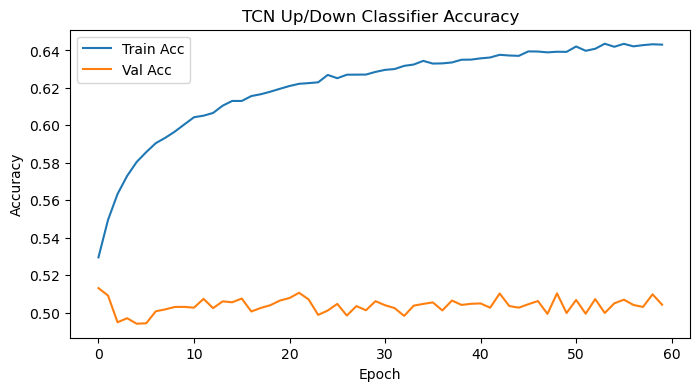

In [11]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'],    label='Train Acc')
plt.plot(history.history['val_accuracy'],label='Val Acc')
plt.title('TCN Up/Down Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Third part: Predict over all symbols using (Long, short, Long-Short and Asset-holding technique)

### 9) Predict on test set

In [12]:
probs_all = model.predict(X_test).flatten()
preds_all = (probs_all >= 0.5).astype(int)

2257/2257 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


### 10) Backtest & compute metrics for all symbols

In [14]:
def sharpe_ratio(returns):
    """
    Non-annualized Sharpe ratio: mean / std.
    """
    return returns.mean() / returns.std()


def max_drawdown(cum_returns):
    """
    Maximum drawdown from a cumulative returns series.
    """
    running_max = np.maximum.accumulate(cum_returns)
    drawdowns   = cum_returns / running_max - 1
    return drawdowns.min()

results = []

for sym in np.unique(symbols_test):
    mask      = (symbols_test == sym)
    times_sym = times_test[mask]
    rets_sym  = rets_test[mask]
    preds_sym = preds_all[mask]

    # Sort chronologically
    order     = np.argsort(times_sym)
    rets_sym  = rets_sym[order]
    preds_sym = preds_sym[order]

    # Strategy return streams
    strat_returns = {
        "Long Only":      preds_sym * rets_sym,
        "Short Only":     (1 - preds_sym) * (-rets_sym),
        "Long–Short":     np.where(preds_sym==1, 1, -1) * rets_sym,
        "Buy & Hold":     rets_sym
    }

    # Compute Sharpe & Max Drawdown
    for strat, r in strat_returns.items():
        cum = np.cumprod(1 + r)
        results.append({
            "symbol":        sym,
            "strategy":      strat,
            "Sharpe":        sharpe_ratio(r),
            "Max Drawdown":  max_drawdown(cum)
        })

### 11) Aggregate results into DataFrame & pivot

In [15]:
results_df = pd.DataFrame(results)

pivot = results_df.pivot(
    index="symbol",
    columns="strategy",
    values=["Sharpe", "Max Drawdown"]
)

# Flatten MultiIndex columns: "Strategy Metric"
pivot.columns = [
    f"{strategy} {metric}"
    for metric, strategy in pivot.columns
]

pivot = pivot.reset_index()

# Round numeric values for readability
pivot.iloc[:, 1:] = pivot.iloc[:, 1:].round(3)

12) Extract separate DataFrames for Sharpe & Drawdown

In [16]:
def get_sharpe_df(pivot_df):
    """
    Return a DataFrame of Sharpe ratios for each symbol/strategy.
    """
    cols = [c for c in pivot_df.columns if c.endswith("Sharpe")]
    df = pivot_df[["symbol"] + cols].copy()
    df.columns = ["symbol"] + [c.replace(" Sharpe", "") for c in cols]
    return df


def get_drawdown_df(pivot_df):
    """
    Return a DataFrame of Max Drawdowns for each symbol/strategy.
    """
    cols = [c for c in pivot_df.columns if c.endswith("Max Drawdown")]
    df = pivot_df[["symbol"] + cols].copy()
    df.columns = ["symbol"] + [c.replace(" Max Drawdown", "") for c in cols]
    return df


sharpe_df    = get_sharpe_df(pivot)
drawdown_df  = get_drawdown_df(pivot)

### 13) Display the two summary tables

In [17]:
print("=== Sharpe Ratios by Symbol ===")
print(sharpe_df)

print("\n=== Max Drawdowns by Symbol ===")
print(drawdown_df)

=== Sharpe Ratios by Symbol ===
    symbol  Buy & Hold  Long Only  Long–Short  Short Only
0        A       0.057     -0.004      -0.061      -0.075
1     AAPL      -0.046     -0.040      -0.005       0.026
2     ABBV       0.053      0.030      -0.009      -0.045
3     ABNB      -0.059     -0.060      -0.025       0.024
4      ABT       0.008      0.060       0.077       0.049
..     ...         ...        ...         ...         ...
473    XYL       0.094      0.015      -0.070      -0.136
474    YUM       0.069      0.052       0.004      -0.046
475    ZBH       0.004      0.000      -0.004      -0.005
476   ZBRA      -0.025     -0.033      -0.033      -0.009
477    ZTS      -0.030      0.071       0.146       0.151

[478 rows x 5 columns]

=== Max Drawdowns by Symbol ===
    symbol  Buy & Hold  Long Only  Long–Short  Short Only
0        A      -0.014     -0.013      -0.031      -0.024
1     AAPL      -0.019     -0.014      -0.017      -0.011
2     ABBV      -0.010     -0.010      -0

## Fourth part: Cumprod plot of one specific stock

In [18]:
sel  = "AAPL"
mask = (symbols_test == sel)
X_sel     = X_test[mask]
times_sel = times_test[mask]
rets_sel  = rets_test[mask]
probs = model.predict(X_sel).flatten()
preds = (probs >= 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


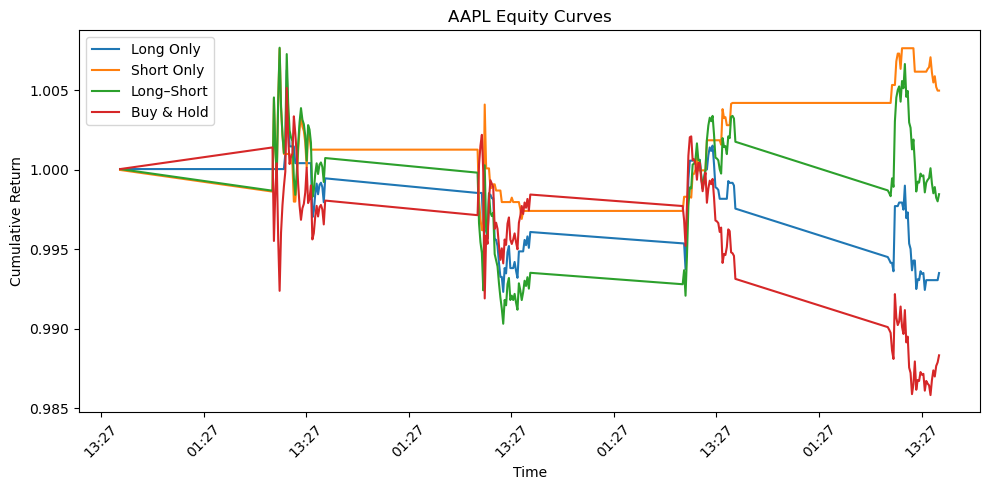

In [19]:
import matplotlib.dates as mdates

order     = np.argsort(times_sel)
times_sel = times_sel[order]
rets_sel  = rets_sel[order]
preds     = preds[order]

ret_long       = preds * rets_sel
ret_short      = (1 - preds) * (-rets_sel)
ret_long_short = np.where(preds==1, 1, -1) * rets_sel
ret_bh         = rets_sel

cum_long       = np.cumprod(1 + ret_long)
cum_short      = np.cumprod(1 + ret_short)
cum_long_short = np.cumprod(1 + ret_long_short)
cum_bh         = np.cumprod(1 + ret_bh)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(times_sel, cum_long,       label='Long Only')
ax.plot(times_sel, cum_short,      label='Short Only')
ax.plot(times_sel, cum_long_short, label='Long–Short')
ax.plot(times_sel, cum_bh,         label='Buy & Hold')

# set major ticks every 10 minutes
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=720))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.set_title(f'{sel} Equity Curves')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Return')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()